In [ ]:
## Quickly checking out the drivers of Tony Benn's popularity

## Checking out trade union membership variables

In [1]:
# %%time
## Just an easy way to load utility functions
dataset_name = "W19_only"
df_list = []

%matplotlib inline 
%run f2f_header.py {dataset_name} {df_list}


Toggle code

AttributeError: module 'brotli' has no attribute 'error'

In [6]:
global BES_label_list, BES_df_list

BES_df_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_df_list.pickle", "rb" ) )
f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')
BES_label_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_label_list.pickle", "rb" ) )
demo_var_dict = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\demo_var_dict.pickle", "rb" ) )
var_type_dict_nonans = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\var_type_dict_nonans.pickle", "rb" ) )


In [7]:
generic_cols = f2f_harmonised.columns
list_of_scale_harm_vars = ["Age","year_past_min_sch_leave_age","in_school_past_min_age"]

In [4]:
%run f2f_utility.py

AttributeError: module 'brotli' has no attribute 'error'

In [8]:
## FIXES


var_type_dict_nonans["1964"]["v860"]="nominal"
var_type_dict_nonans["1964"]["v881"]="nominal"
var_type_dict_nonans["1964"]["v882"]="nominal"

In [10]:
for ge in f2f_harmonised["dataset"].unique():
    print(ge)
    print( {k:v for k,v in BES_label_list[ge].items() if "benn" in v.lower()} )

In [11]:
BES_df_list["1974_oct"]["oct150a"].value_counts(dropna=False)

0      522
5      335
4      249
6      214
2      211
dk     197
7      157
3      152
1      118
8      118
10      37
9       36
NaN     19
Name: oct150a, dtype: int64

In [12]:
benn_out_of_ten = BES_df_list["1974_oct"]["oct150a"].replace("dk",np.nan).astype(float)

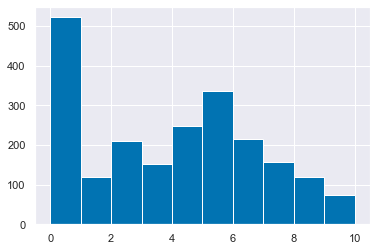

In [13]:
benn_out_of_ten.hist()

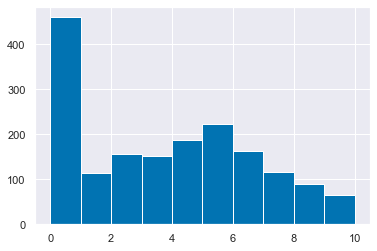

In [17]:
# benn_out_of_ten = BES_df_list["1974_oct"]["oct150a"].replace("dk",np.nan).astype(float)
BES_df_list["1979"]["m150a177"].replace({"not ascertained":np.nan,"dk":np.nan,"refused":np.nan}).astype(float).hist()



MSE: 4.23, MAE: 1.61, EV: 0.47, R2: 0.47


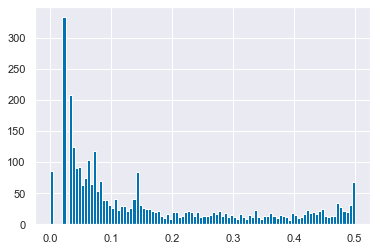

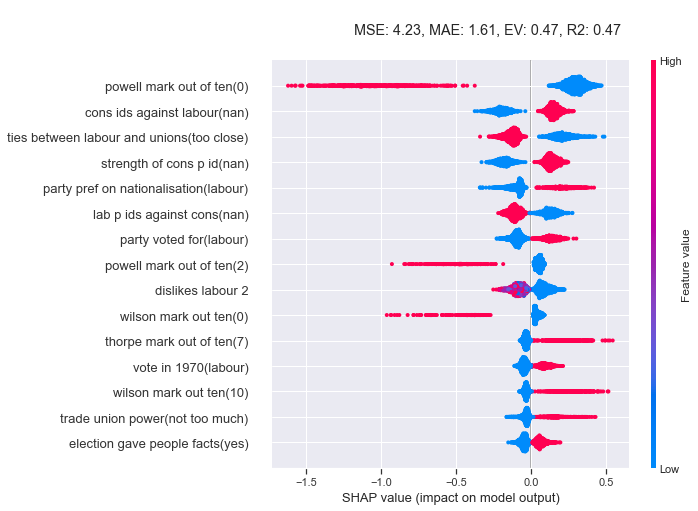

In [34]:
# %%time

ge="1974_oct"
benn_out_of_ten = BES_df_list["1974_oct"]["oct150a"].replace("dk",np.nan).astype(float)
f2f_harmonised["benn_out_of_ten"]=np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"benn_out_of_ten"] = benn_out_of_ten
list_of_scale_harm_vars.append("benn_out_of_ten")


predicting = False
generic_cols = f2f_harmonised.columns

harm_vars = ["wt","age","housing_det","inc","inc_det","gender_complete","vote_complete","benn_out_of_ten"]

# 
target_var = "benn_out_of_ten"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None
var_stub = target_var
min_features = 15
drop_std_thresh = 0.1
drop_vars = ['oct150a']
#'v856','v857a','v857b'
specific_vars = False
demo_var_only = False
multiclass = False
dependence_plot = False

#####################
if predicting:
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].isnull()
else: ## only non-null values
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].notnull()

alg = get_xgboost_alg(classification_problem=multiclass)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                       specific_vars=specific_vars, drop_after_dummying = [])
stds = df_pred[mask].std()

# sanity check for std distribution of variables
df_pred[mask].std()[df_pred[mask].std()<1].hist(bins=100)

low_var_list = list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)

drop_after_dummying = [x for x in low_var_list if not re.match("wt|"+var_stub,x)]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                                                        alg=alg,multi_class_target=multiclass,specific_vars=specific_vars,
                                                        drop_after_dummying = drop_after_dummying,wt_col = "wt")
if predicting:
    # setup df back up
    df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
           var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                          drop_after_dummying = [])
    # use fitted algorithm to predict values
    pred = pd.Series(alg.predict(df_pred[train_columns]),index=f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,var_stub].index)

    pred.value_counts(dropna=False)

In [32]:
pd.Series(df_pred.columns).tail(50)

1033                                 housing_det|OWN
1034                             housing_det|RENT-LA
1035                             housing_det|RENT-PR
1036                                 housing_det|nan
1037        resp soc-econ group(na or no occupation)
1038                          resp soc-econ group(1)
1039                          resp soc-econ group(2)
1040                          resp soc-econ group(3)
1041                          resp soc-econ group(4)
1042                          resp soc-econ group(5)
1043                          resp soc-econ group(6)
1044                          resp soc-econ group(7)
1045                          resp soc-econ group(8)
1046                          resp soc-econ group(9)
1047                         resp soc-econ group(10)
1048                         resp soc-econ group(11)
1049                         resp soc-econ group(12)
1050                         resp soc-econ group(13)
1051                         resp soc-econ gro

MSE: 7.33, MAE: 2.26, EV: 0.09, R2: 0.08


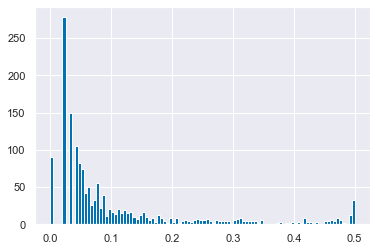

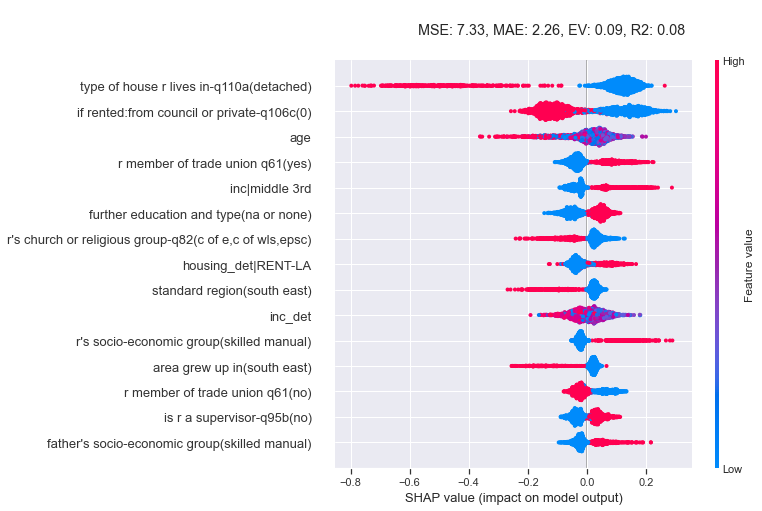

In [44]:
# %%time
ge="1979"

benn_out_of_ten = BES_df_list["1979"]["m150a177"].replace({"not ascertained":np.nan,"dk":np.nan,"refused":np.nan}).astype(float)
f2f_harmonised["benn_out_of_ten"]=np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"benn_out_of_ten"] = benn_out_of_ten
list_of_scale_harm_vars.append("benn_out_of_ten")

predicting = False
generic_cols = f2f_harmonised.columns

harm_vars = ["wt","age","housing_det","inc","inc_det","gender_complete","benn_out_of_ten"]
# "vote_complete",
target_var = "benn_out_of_ten"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None
var_stub = target_var
min_features = 15
drop_std_thresh = 0.1
drop_vars = ['oct150a']
#'v856','v857a','v857b'
specific_vars = False
demo_var_only = True
multiclass = False
dependence_plot = False

#####################
if predicting:
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].isnull()
else: ## only non-null values
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].notnull()

alg = get_xgboost_alg(classification_problem=multiclass)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                       specific_vars=specific_vars, drop_after_dummying = [])
stds = df_pred[mask].std()

# sanity check for std distribution of variables
df_pred[mask].std()[df_pred[mask].std()<1].hist(bins=100)

low_var_list = list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)

drop_after_dummying = [x for x in low_var_list if not re.match("wt|"+var_stub,x)]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                                                        alg=alg,multi_class_target=multiclass,specific_vars=specific_vars,
                                                        drop_after_dummying = drop_after_dummying,wt_col = "wt")
if predicting:
    # setup df back up
    df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
           var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                          drop_after_dummying = [])
    # use fitted algorithm to predict values
    pred = pd.Series(alg.predict(df_pred[train_columns]),index=f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,var_stub].index)

    pred.value_counts(dropna=False)

In [ ]:
### trade union variables

In [116]:
for ge in f2f_harmonised["dataset"].unique():
    print(ge)
    print( {k:v for k,v in BES_label_list[ge].items() if re.search("TU |TU\\|TU\/|-TU|TRADE UNION|Trade union|trade union",v)} )
# 2019: 'y08': 'Trade union/staff association member'

2019
{'b12_2': 'Conservatives look after interests of trade unions', 'b13_2': 'Labour look after interests of trade unions', 'f01_5': 'There is no need for strong trade unions to protect working conditions and wages', 'w11': 'Trade unions have too much power?', 'y08': 'Trade union/staff association member'}
2017
{'b12_2': 'Conservatives look after interests of trade unions', 'b13_2': 'Labour look after interests of trade unions', 'f01_5': "There is no need for strong trade unions to protect employees' working condition", 'w11': 'W11 Thinking now of trade unions and big business in this country. First, do you', 'y08': 'Trade union/staff association member'}
2015
{'b12_2': 'Conservatives look after interests of trade unions', 'b13_2': 'Labour look after interests of trade unions', 'f01_5': "There is no need for strong trade unions to protect employees' working condition", 'j15_06': 'Responsible for GB debt: Trade unions', 'w11': 'W11 Thinking now of trade unions and big business in this 

In [ ]:
2019 'y08': 'Trade union/staff association member'
2017 'y08': 'Trade union/staff association member'
2015 'y08': 'Trade union/staff association member'
2010 'zq94_1': 'trade union staff assoc member(3rd)'
2005 'tq80a': 'combined-trade union member now'
2001 'trades': 'trade union member-summary',
1997 'unionsa2': 'are you now a member of a trade union? q727', 'unionsa': 'now member trade union? [ever had job] q728',
1992  'v903c': 'r now a member of a tu or staff association? q903c', 'v903d': 'r ever been member of tu/sa [notnow] q903d',
1987 'v49c': "respondent's t.u. membership", 'v49d': 'past membership of t.u.s.',
1983 'q52c': '[if ever worked] r member of trade union'
1979 'm245190': 'r member of trade union q61',
1974_oct 'oct245': 'respondents trade union', 'oct246': 'husbands trade union', 'oct247': 'wifes trade union', 'oct248': 'other family trade union'
1974_feb 'feb245': 'respondents trade union', 'feb246': 'husbands trade union', 'feb247': 'wifes trade union', 'feb248': 'other family trade union'
1970 'v859': 'IF R IS MEMBER OF TU  64', 'v860': 'TRADE UNION BELONGS TO64','v877': 'BELONG TRADE UNION  1963',

In [26]:
BES_df_list[ge]['unionsa'].value_counts(dropna=False)

no                        2706
yes: trade union           654
skp,never had job          121
yes: staff association     119
not     answered            14
don't   know                 1
Name: unionsa, dtype: int64

In [59]:
ge = "1970"
temp = BES_df_list[ge]['v859'].replace({1:"YES",5:"NO",8:np.nan,9:np.nan,0:np.nan})

# BES_df_list[ge]['v877'][temp.isnull()].value_counts()
temp.loc[temp.isnull()&(BES_df_list[ge]['v879']==1)] = "YES"
temp.loc[temp.isnull()&(BES_df_list[ge]['v877']==5)] = "NO"
temp.value_counts(dropna=False)

NO     1369
NaN     992
YES     561
Name: v859, dtype: int64

In [51]:
BES_df_list[ge]['v879'][temp.isnull()].value_counts()

0.0    1462
2.0     200
1.0     127
6.0      30
7.0      25
4.0       5
9.0       1
8.0       1
5.0       1
Name: v879, dtype: int64

In [45]:
ge = "1970"
BES_df_list[ge]['v879'].value_counts(dropna=False).sort_index()

0.0    2118
1.0     433
2.0     276
3.0       9
4.0      10
5.0       1
6.0      42
7.0      31
8.0       1
9.0       1
Name: v879, dtype: int64

In [33]:
# 1997
temp = BES_df_list[ge][['unionsa','unionsa2']]\
    .replace("not     answered",np.nan).replace("don't   know",np.nan)\
    .fillna(method='ffill',axis=1).fillna(method='bfill',axis=1)
temp['unionsa'].value_counts()

no                        2709
yes: trade union           654
skp,never had job          121
yes: staff association     119
Name: unionsa, dtype: int64

In [62]:
ge="1997"
BES_df_list[ge]['unionsa2'].cat.categories

Index(['skp,never had job', 'yes: trade union', 'yes: staff association', 'no',
       'don't   know', 'not     answered'],
      dtype='object')

In [40]:
BES_df_list[ge]['oct245'].value_counts().index

CategoricalIndex(['not in union', 'other mixed tuc', 'white collar tuc',
                  'tgwu', 'aeu', 'unclassifiable', 'nugmw', 'num',
                  'white collar not tuc', 'etu', 'usdaw', 'dk which union',
                  'nur'],
                 categories=['not in union', 'white collar tuc', 'white collar not tuc', 'other mixed tuc', 'aeu', 'etu', 'nugmw', 'num', ...], ordered=True, dtype='category')

In [11]:
tumember_dict ={'Not stated':np.nan, "Don't know":np.nan,"don't know":np.nan,'refused':np.nan,"not     answered":np.nan,"don't   know":np.nan,
              "not answered":np.nan,"skipped":np.nan,0:np.nan,'dk':np.nan,8:np.nan,9999:np.nan,
          'yes':"YES","yes now":"YES",
          'Yes: trade union':"YES",'yes: trade union':"YES",'yes, trade union':"YES",'yes:trade union':"YES",1:"YES",
          'Yes: staff association':"YES",'yes: staff association':"STAFF",'yes, staff association':"YES",'yes:staff association':"YES","yes, staff assoc.":"YES",2:"YES",
          'no, used to':"NO","yes used to be":"NO","not in union":"NO",
          'No':"NO","no":"NO",'no, never':"NO",3:"NO",
          'skp,never had job':"NO",'skp,nvr paid job had':"NO",
          'skp,fulltime education':"NO",
          # oct245
          'other mixed tuc':"YES", 'white collar tuc':"YES",
                  'tgwu':"YES", 'aeu':"YES", 'unclassifiable':"YES", 'nugmw':"YES", 'num':"YES",
                  'white collar not tuc':"YES", 'etu':"YES", 'usdaw':"YES", 'dk which union':"YES",
                  'nur':"YES",
         }
tumember_det_dict ={'Not stated':np.nan, "Don't know":np.nan,"don't know":np.nan,'refused':np.nan,"not     answered":np.nan,"don't   know":np.nan,
                  "not answered":np.nan,"skipped":np.nan,0:np.nan,'dk':np.nan,8:np.nan,9999:np.nan,
              'yes':"YES","yes now":"YES",
              'Yes: trade union':"TU",'yes: trade union':"TU",'yes, trade union':"TU",'yes:trade union':"TU",1:"TU",
              'Yes: staff association':"STAFF",'yes: staff association':"STAFF",'yes, staff association':"STAFF",'yes:staff association':"STAFF","yes, staff assoc.":"STAFF",2:"STAFF",
              'no, used to':"PAST","yes used to be":"PAST",
              'No':"NO","no":"NO",'no, never':"NO",3:"NO","not in union":"NO",
              'skp,never had job':"NOJOB",'skp,nvr paid job had':"NOJOB",
              'skp,fulltime education':"FTED",
              # oct245
              'other mixed tuc':"TU", 'white collar tuc':"TU",
                      'tgwu':"TU", 'aeu':"TU", 'unclassifiable':"TU", 'nugmw':"TU", 'num':"TU",
                      'white collar not tuc':"TU", 'etu':"TU", 'usdaw':"TU", 'dk which union':"TU",
                      'nur':"TU",
             }

In [12]:
f2f_harmonised["tumember"] = np.nan
f2f_harmonised["tumember_det"] = np.nan

ge="2019"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["y08"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["y08"].replace(tumember_det_dict)

ge="2017"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["y08"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["y08"].replace(tumember_det_dict)

ge="2015"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["y08"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["y08"].replace(tumember_det_dict)

ge="2010"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["zq94_1"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["zq94_1"].replace(tumember_det_dict)

ge="2005"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["tq80a"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["tq80a"].replace(tumember_det_dict)

ge="2001"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["trades"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["trades"].replace(tumember_det_dict)

ge="1997"
# 1997
temp = BES_df_list[ge][['unionsa','unionsa2']]\
    .replace("not     answered",np.nan).replace("don't   know",np.nan)\
    .fillna(method='ffill',axis=1).fillna(method='bfill',axis=1)
# temp['unionsa'].value_counts()
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = temp["unionsa"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = temp["unionsa2"].replace(tumember_det_dict)

ge="1992"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["v903c"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["v903c"].replace(tumember_det_dict)

ge="1987"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["v49c"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["v49c"].replace(tumember_det_dict)

ge="1983"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["q52c"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["q52c"].replace(tumember_det_dict)

ge="1979"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["m245190"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["m245190"].replace(tumember_det_dict)

ge="1974_oct"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["oct245"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["oct245"].replace(tumember_det_dict)

ge="1974_feb"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = BES_df_list[ge]["feb245"].replace(tumember_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = BES_df_list[ge]["feb245"].replace(tumember_det_dict)

ge = "1970"
temp = BES_df_list[ge]['v859'].replace({1:"YES",5:"NO",8:np.nan,9:np.nan,0:np.nan})
temp.loc[temp.isnull()&(BES_df_list[ge]['v879']==1)] = "YES"
temp.loc[temp.isnull()&(BES_df_list[ge]['v877']==5)] = "NO"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = temp
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = temp

ge = "1966"
temp = BES_df_list[ge]['v859'].replace({1:"YES",5:"NO",8:np.nan,9:np.nan,0:np.nan})
temp.loc[temp.isnull()&(BES_df_list[ge]['v879']==1)] = "YES"
temp.loc[temp.isnull()&(BES_df_list[ge]['v877']==5)] = "NO"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = temp
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = temp

ge = "1964"
temp = BES_df_list[ge]['v859'].replace({1:"YES",5:"NO",8:np.nan,9:np.nan,0:np.nan})
temp.loc[temp.isnull()&(BES_df_list[ge]['v879']==1)] = "YES"
temp.loc[temp.isnull()&(BES_df_list[ge]['v877']==5)] = "NO"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = temp
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = temp

ge = "1959"
temp = BES_df_list[ge]['v859'].replace({1:"YES",5:"NO",8:np.nan,9:np.nan,0:np.nan})
temp.loc[temp.isnull()&(BES_df_list[ge]['v879']==1)] = "YES"
temp.loc[temp.isnull()&(BES_df_list[ge]['v877']==5)] = "NO"
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember"] = temp
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"tumember_det"] = temp


In [13]:
f2f_harmonised["tumember_det"].value_counts()

NO       35013
TU        5937
YES       4491
PAST      1977
STAFF      709
FTED        85
NOJOB       65
Name: tumember_det, dtype: int64

In [14]:
f2f_harmonised.groupby("dataset")[["tumember","tumember_det"]].apply(lambda x: x.isnull().sum())

,tumember,tumember_det
dataset,,
1959,992,992
1964,992,992
1966,992,992
1970,992,992
1974_feb,0,0
1974_oct,0,0
1979,36,36
1983,188,188
1987,162,162


In [102]:
pd.get_dummies(f2f_harmonised[["tumember","bloc_complete"]]).corr().loc[['bloc_complete_Left-Lib',
       'bloc_complete_Neither', 'bloc_complete_Right-Auth'],['tumember_NO', 'tumember_YES']]

,tumember_NO,tumember_YES
bloc_complete_Left-Lib,-0.117902,0.148837
bloc_complete_Neither,0.046446,-0.062733
bloc_complete_Right-Auth,0.101830,-0.103452


In [111]:
pd.get_dummies(f2f_harmonised[["tumember_det","bloc_complete"]]).corr()\
    .loc[['bloc_complete_Left-Lib',
       'bloc_complete_Neither', 'bloc_complete_Right-Auth'],
['tumember_det_FTED', 'tumember_det_NO', 'tumember_det_NOJOB',
       'tumember_det_PAST', 'tumember_det_STAFF', 'tumember_det_TU',
       'tumember_det_YES']]

,tumember_det_FTED,tumember_det_NO,tumember_det_NOJOB,tumember_det_PAST,tumember_det_STAFF,tumember_det_TU,tumember_det_YES
bloc_complete_Left-Lib,0.005281,-0.124971,-0.013169,0.029015,0.012256,0.122116,0.075037
bloc_complete_Neither,0.002274,0.043436,0.011964,0.000558,-0.018238,-0.045699,-0.031273
bloc_complete_Right-Auth,-0.007502,0.110306,0.004823,-0.028904,0.003610,-0.086429,-0.056468


In [112]:
f2f_harmonised[["tumember","tumember_det"]].to_pickle("E:\\BES_analysis_data\\Face_to_face\\tumember.zip", compression='zip')

In [ ]:
# 2005
# 1        775
# 2         99
# 3       3283
# 8          2
# 9999       2

# 1 Yes, trade union
# 2 Yes, staff association
# 3 No

In [52]:
ge = "2005"
BES_df_list[ge]['tq80a'].value_counts(dropna=False).sort_index()

1        775
2         99
3       3283
8          2
9999       2
Name: tq80a, dtype: int64

In [ ]:
{
    
}

In [56]:
ge = "1970"
{k:v for k,v in BES_label_list[ge].items() if re.search("TU |TU\\|TU\/|-TU|TRADE UNION|Trade union|trade union|T\.U\.",v)}

{'v227': 'TRADE UNION POWER   1963',
 'v228': 'TRADE UNION POWER   1964',
 'v229': 'TRADE UNION POWER   1966',
 'v230': 'TRADE UNION POWER     70',
 'v260': 'LABOUR-TRADE UNION TIE64',
 'v261': 'LABOUR-TRADE UNION TIE66',
 'v262': 'LABOUR-TRADE UNION TIE70',
 'v859': 'IF R IS MEMBER OF TU  64',
 'v860': 'TRADE UNION BELONGS TO64',
 'v861': 'NO. OF CO-WRKRS IN TU 64',
 'v862': 'COMPULS TU MEMBERSHIP 64',
 'v863': 'IF R READS TU JOURNAL 64',
 'v864': 'NAME TU JOURNAL R READ64',
 'v865': 'INTEREST IN TU JOURNAL64',
 'v866': 'POL NEWS IN TU JOURNAL64',
 'v867': 'KIND OF TU POL ARTICLE64',
 'v868': 'TU OFFICIAL INFL VOTE?64',
 'v869': 'TU STEWARD ASK TO VOTE64',
 'v870': 'R NON-TU/CO-WORKERS TU64',
 'v871': 'R NON-TU/#COWORKERS TU64',
 'v873': 'WHY DID NOT JOIN TU   64',
 'v874': 'JOIN TU IF ASKED?   1964',
 'v875': 'WHY WOULD JOIN TU   1964',
 'v876': 'WHY WOULD NOT JOIN TU 64',
 'v877': 'BELONG TRADE UNION  1963',
 'v878': 'TU MBR IN HOUSEHOLD?  64',
 'v879': 'WHO BELONGS TU      1963',
 

In [12]:
ge = "1987"
{k:v for k,v in BES_label_list[ge].items() if re.search("member",v)}

{'v49c': "respondent's t.u. membership",
 'v49d': 'past membership of t.u.s.',
 'v51d': "spouse's t.u. membership",
 'v67a': 'respondent member of any political party',
 'v67b': 'if labour party member: through t.u. or individual'}

In [ ]:
# tu member now, tu member ever, which tu

In [13]:
BES_label_list[ge]["v859"]

'IF R IS MEMBER OF TU  64'

In [16]:
ge = "1964"
BES_df_list[ge]["v859"].value_counts(dropna=False)

# IF R IS A MEMBER OF A TU 1964
# 1. YES
# 5. NO
# 8. Not interviewed 1964
# 9. DK
# 0. NA. IMAP. CODED 5 on v858 (NO JOB)

8.0    1094
0.0     757
5.0     636
1.0     434
9.0       1
Name: v859, dtype: int64

In [11]:
ge = "1964"
BES_df_list[ge]["v860"].value_counts(dropna=False)

NaN      2503
28.0       77
48.0       49
251.0      32
2.0        29
         ... 
20.0        1
123.0       1
52.0        1
114.0       1
56.0        1
Name: v860, Length: 81, dtype: int64

In [12]:
BES_df_list[ge]["v877"].value_counts(dropna=False)

5.0    1165
8.0     913
1.0     809
0.0      27
9.0       8
Name: v877, dtype: int64

In [ ]:
## How about quick fish to see *which* TU variables are relevant to vote choice?

In [ ]:
# 'v859': 'IF R IS MEMBER OF TU  64',
'v860': 'TRADE UNION BELONGS TO64',
'v861': 'NO. OF CO-WRKRS IN TU 64',
'v862': 'COMPULS TU MEMBERSHIP 64',
'v863': 'IF R READS TU JOURNAL 64',
'v864': 'NAME TU JOURNAL R READ64',
'v865': 'INTEREST IN TU JOURNAL64',
'v866': 'POL NEWS IN TU JOURNAL64',
'v867': 'KIND OF TU POL ARTICLE64',
'v873': 'WHY DID NOT JOIN TU   64',
'v874': 'JOIN TU IF ASKED?   1964',
'v875': 'WHY WOULD JOIN TU   1964',
'v876': 'WHY WOULD NOT JOIN TU 64',
'v877': 'BELONG TRADE UNION  1963',
'v879': 'WHO BELONGS TU      1963',
'v880': 'WHO IS TU MBR IN HSHLD64',
'v881': 'NAME OF TRADE UNION 1963',
'v882': 'TRADE UNION(HSHLD MBR)64',
'v883': 'HOW LONG TU MEMBER  1963',
'v884': 'CLOSE TO TRADE UNION  63',
'v886': 'TRADE UNION VOTING  1963',
'v887': 'TRADE UNION PARTY   1963',
'v888': 'WHY TU MBRS VOTE 1 PTY63'

In [ ]:
# 'v888': 'WHY TU MBRS VOTE 1 PTY63' - only matters for (0) category -> (tu members vote for diff parties?)

In [26]:
list(BES_label_list[ge].keys()).index('v859')

1077

In [119]:
list(BES_label_list[ge].keys())[1077:1105]

['v859',
 'v860',
 'v861',
 'v862',
 'v863',
 'v864',
 'v865',
 'v866',
 'v867',
 'v868',
 'v869',
 'v870',
 'v871',
 'v872',
 'v873',
 'v874',
 'v875',
 'v876',
 'v877',
 'v878',
 'v879',
 'v880',
 'v881',
 'v882',
 'v883',
 'v884',
 'v885',
 'v886']

[23:00:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ACC: 0.57,  F1: 0.57
[23:00:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:00:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

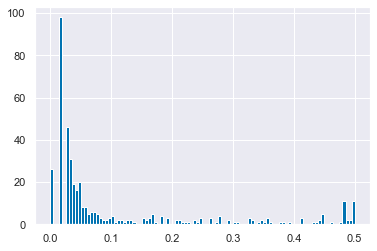

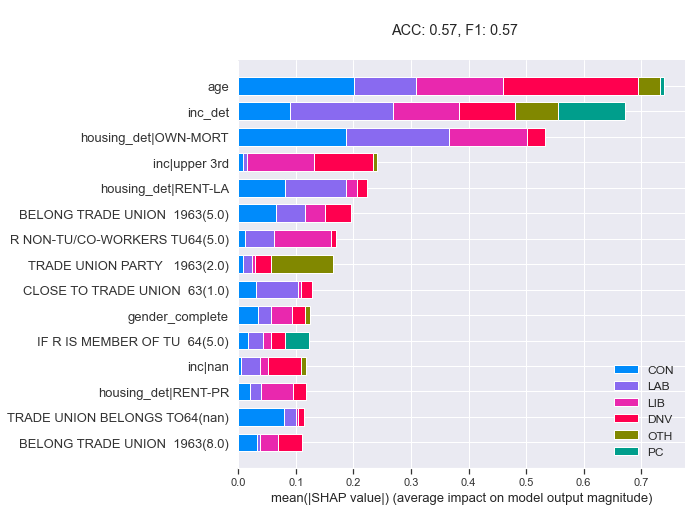

In [55]:
# %%time
ge="1964"


f2f_harmonised["belong_to_union"] = np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"belong_to_union"] = belong_to_union
predicting = False
generic_cols = f2f_harmonised.columns

harm_vars = ["wt","age","housing_det","inc","inc_det","gender_complete","vote_complete"]
# "vote_complete",
target_var = "vote_complete"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None
var_stub = target_var
min_features = 15
drop_std_thresh = 0.1
drop_vars = ["v1153","v1155"]
#'v856','v857a','v857b'
specific_vars = list(BES_label_list[ge].keys())[1077:1104]
demo_var_only = False
multiclass = True
dependence_plot = False

#####################
if predicting:
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].isnull()
else: ## only non-null values
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].notnull()

alg = get_xgboost_alg(classification_problem=multiclass)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                       specific_vars=specific_vars, drop_after_dummying = [])
stds = df_pred[mask].std()

# sanity check for std distribution of variables
df_pred[mask].std()[df_pred[mask].std()<1].hist(bins=100)

low_var_list = list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)

drop_after_dummying = [x for x in low_var_list if not re.match("wt|"+var_stub,x)]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                                                        alg=alg,multi_class_target=multiclass,specific_vars=specific_vars,
                                                        drop_after_dummying = drop_after_dummying,wt_col = "wt")
if predicting:
    # setup df back up
    df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
           var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                          drop_after_dummying = [])
    # use fitted algorithm to predict values
    pred = pd.Series(alg.predict(df_pred[train_columns]),index=f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,var_stub].index)

    pred.value_counts(dropna=False)

In [ ]:
'v877': 'BELONG TRADE UNION  1963',

In [64]:
BES_df_list["1964"]["v877"].value_counts()
replace_dict = {1:"YES",5:"NO",8:"NOT INTERVIEWED",9:"DK",0:"NA"}
belong_trade_union_63 = BES_df_list["1964"]["v877"].replace(replace_dict)
belong_trade_union_63.value_counts()

NO                 1165
NOT INTERVIEWED     913
YES                 809
NA                   27
DK                    8
Name: v877, dtype: int64

In [76]:
# v859: IF R IS TU MEMBER 1964
BES_df_list["1964"]["v859"].value_counts()
replace_dict = {1:"YES",5:"NO",8:"NOT INTERVIEWED",9:"DK",0:"NA"}

belong_trade_union_64 = BES_df_list["1964"]["v859"].replace(replace_dict)
belong_trade_union_64.value_counts()

NOT INTERVIEWED    1094
NA                  757
NO                  636
YES                 434
DK                    1
Name: v859, dtype: int64

In [87]:
belong_trade_union_64[belong_trade_union_63=="YES"].value_counts()

YES                295
NA                 203
NOT INTERVIEWED    188
NO                 122
DK                   1
Name: v859, dtype: int64

In [72]:
replace_dict = {1:"YES",5:"NO",9:"NOT INTERVIEWED",0:"NA"}
have_a_job = BES_df_list["1964"]["v858"].replace(replace_dict)
have_a_job.value_counts()

NOT INTERVIEWED    1094
YES                1089
NO                  704
NA                   35
Name: v858, dtype: int64

In [88]:
belong_trade_union = belong_trade_union_64.copy()
belong_trade_union.loc[have_a_job=="NO"] = "NO JOB"
belong_trade_union = belong_trade_union.replace({"NOT INTERVIEWED":np.nan,"NA":np.nan,"DK":np.nan})
belong_trade_union.loc[belong_trade_union.isnull()] = belong_trade_union_63.loc[belong_trade_union.isnull()]
belong_trade_union = belong_trade_union.replace({"NOT INTERVIEWED":np.nan,"NA":np.nan,"DK":np.nan})
belong_trade_union.value_counts(dropna=False)

NO        928
NO JOB    704
YES       702
NaN       588
Name: v877, dtype: int64

In [74]:
belong_trade_union_64[have_a_job=="NO"].value_counts()

NA    704
Name: v859, dtype: int64

In [92]:
belong_trade_union_64[BES_df_list["1964"]["v860"].isnull()].value_counts()

NOT INTERVIEWED    1094
NA                  757
NO                  636
YES                  15
DK                    1
Name: v859, dtype: int64

In [95]:
belong_trade_union[belong_trade_union_63=="YES"].value_counts()

YES       618
NO JOB    191
Name: v877, dtype: int64

In [ ]:
belong_trade_union[BES_df_list["1964"]["v860"].isnull()].value_counts()

In [ ]:
'v870': 'R NON-TU/CO-WORKERS TU64'
# if you're *not* a union member, are any of the people at your workplace who do the same job union members?
# NA includes any answer to 859 TU membership other than "NO"

In [122]:
BES_df_list["1964"]["v870"].value_counts()

union_coworkers = BES_df_list["1964"]["v870"].replace({1:"YES",5:"NO",9:"DK",0:"NA"})
union_coworkers.value_counts(dropna=False)

NA     2367
NO      410
YES      99
DK       46
Name: v870, dtype: int64

In [133]:
belong_trade_union.loc[union_coworkers=="NO"] = "NOT A UNIONISED JOB"

In [ ]:
'v884': 'CLOSE TO TRADE UNION  63',

In [131]:
close_to_tu = BES_df_list["1964"]["v884"].replace({1:"PRETTY CLOSE",5:"NOT MUCH CLOSER",9:"DK",0:"NA"})
close_to_tu.value_counts()

NA                 2117
NOT MUCH CLOSER     393
PRETTY CLOSE        297
DK                  115
Name: v884, dtype: int64

In [132]:
belong_trade_union[close_to_tu=="PRETTY CLOSE"].value_counts()

YES                    214
NO JOB                  54
NOT A UNIONISED JOB     29
Name: v877, dtype: int64

In [69]:
pd.concat([belong_trade_union_63,belong_trade_union_64],axis=1).apply(lambda x: "|".join(x),axis=1).value_counts()

NOT INTERVIEWED|NOT INTERVIEWED    566
NO|NA                              403
NO|NO                              377
NO|NOT INTERVIEWED                 330
YES|YES                            295
YES|NA                             203
YES|NOT INTERVIEWED                188
NOT INTERVIEWED|NA                 134
NOT INTERVIEWED|NO                 132
YES|NO                             122
NOT INTERVIEWED|YES                 81
NO|YES                              55
NA|NA                               10
NA|NOT INTERVIEWED                   9
DK|NA                                7
NA|NO                                5
NA|YES                               3
DK|NOT INTERVIEWED                   1
YES|DK                               1
dtype: int64

[14:33:36] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ACC: 0.57,  F1: 0.57
[14:33:37] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:33:37] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

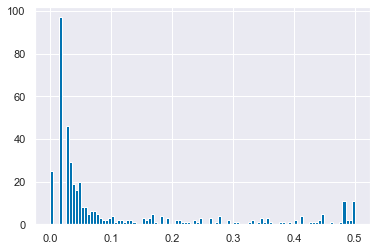

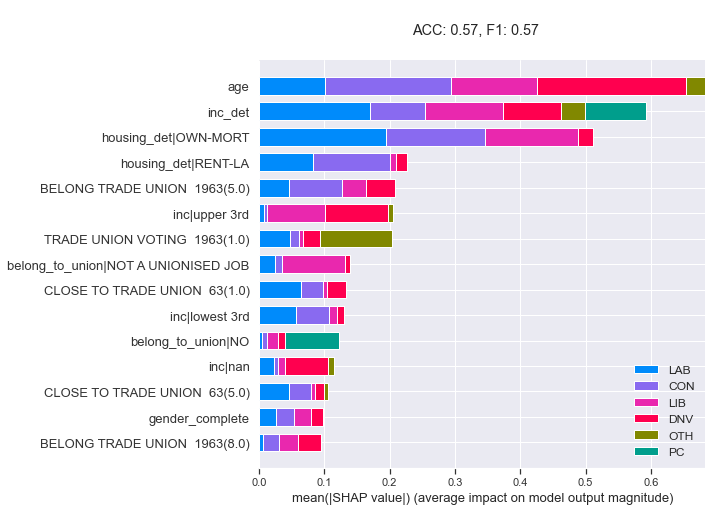

In [134]:
# %%time
ge="1964"


f2f_harmonised["belong_to_union"] = np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"belong_to_union"] = belong_trade_union
predicting = False
generic_cols = f2f_harmonised.columns

harm_vars = ["wt","age","housing_det","inc","inc_det","gender_complete","vote_complete","belong_to_union"]
# "vote_complete",
target_var = "vote_complete"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None
var_stub = target_var
min_features = 15
drop_std_thresh = 0.1
drop_vars = ["v1153","v1155"]
#'v856','v857a','v857b'
specific_vars = list(BES_label_list[ge].keys())[1077:1105]
demo_var_only = False
multiclass = True
dependence_plot = False

#####################
if predicting:
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].isnull()
else: ## only non-null values
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].notnull()

alg = get_xgboost_alg(classification_problem=multiclass)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                       specific_vars=specific_vars, drop_after_dummying = [])
stds = df_pred[mask].std()

# sanity check for std distribution of variables
df_pred[mask].std()[df_pred[mask].std()<1].hist(bins=100)

low_var_list = list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)

drop_after_dummying = [x for x in low_var_list if not re.match("wt|"+var_stub,x)]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                                                        alg=alg,multi_class_target=multiclass,specific_vars=specific_vars,
                                                        drop_after_dummying = drop_after_dummying,wt_col = "wt")
if predicting:
    # setup df back up
    df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
           var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                          drop_after_dummying = [])
    # use fitted algorithm to predict values
    pred = pd.Series(alg.predict(df_pred[train_columns]),index=f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,var_stub].index)

    pred.value_counts(dropna=False)

[12:34:50] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ACC: 0.58,  F1: 0.58
[12:34:51] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:34:51] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

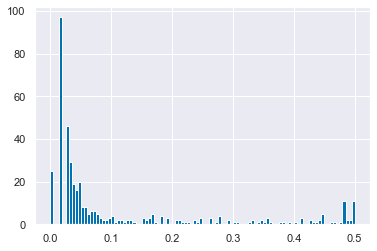

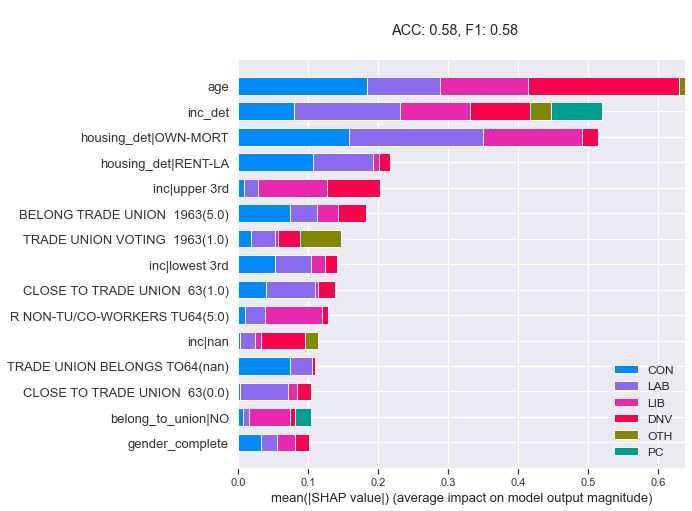

In [97]:
# %%time
ge="1964"


f2f_harmonised["belong_to_union"] = np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"belong_to_union"] = belong_trade_union
predicting = False
generic_cols = f2f_harmonised.columns

harm_vars = ["wt","age","housing_det","inc","inc_det","gender_complete","vote_complete","belong_to_union"]
# "vote_complete",
target_var = "vote_complete"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None
var_stub = target_var
min_features = 15
drop_std_thresh = 0.1
drop_vars = ["v1153","v1155"]
#'v856','v857a','v857b'
specific_vars = list(BES_label_list[ge].keys())[1077:1105]
demo_var_only = False
multiclass = True
dependence_plot = False

#####################
if predicting:
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].isnull()
else: ## only non-null values
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].notnull()

alg = get_xgboost_alg(classification_problem=multiclass)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                       specific_vars=specific_vars, drop_after_dummying = [])
stds = df_pred[mask].std()

# sanity check for std distribution of variables
df_pred[mask].std()[df_pred[mask].std()<1].hist(bins=100)

low_var_list = list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)

drop_after_dummying = [x for x in low_var_list if not re.match("wt|"+var_stub,x)]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                                                        alg=alg,multi_class_target=multiclass,specific_vars=specific_vars,
                                                        drop_after_dummying = drop_after_dummying,wt_col = "wt")
if predicting:
    # setup df back up
    df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
           var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                          drop_after_dummying = [])
    # use fitted algorithm to predict values
    pred = pd.Series(alg.predict(df_pred[train_columns]),index=f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,var_stub].index)

    pred.value_counts(dropna=False)

[12:41:09] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ACC: 0.57,  F1: 0.57
[12:41:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:41:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

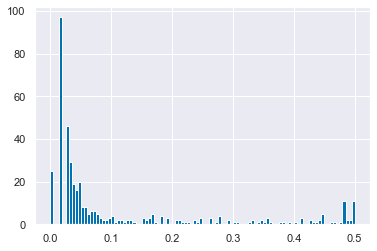

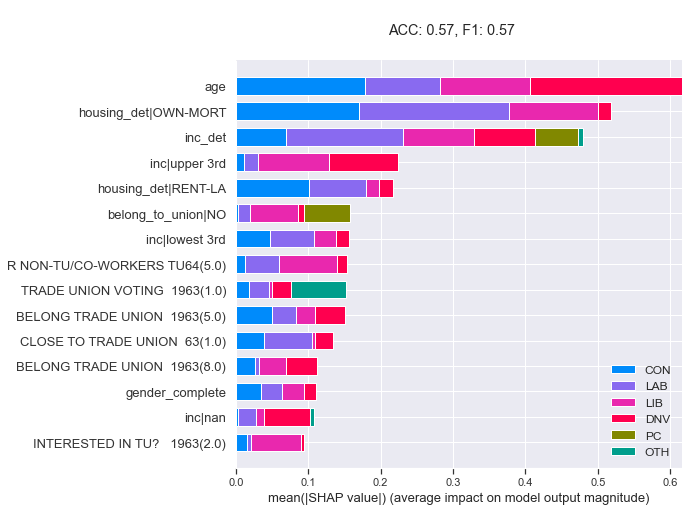

In [112]:
# %%time
ge="1964"


f2f_harmonised["belong_to_union"] = np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"belong_to_union"] = belong_trade_union
predicting = False
generic_cols = f2f_harmonised.columns

harm_vars = ["wt","age","housing_det","inc","inc_det","gender_complete","vote_complete","belong_to_union"]
# "vote_complete",
target_var = "vote_complete"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None
var_stub = target_var
min_features = 15
drop_std_thresh = 0.1
drop_vars = ["v1153","v1155"]
#'v856','v857a','v857b'
specific_vars = list(BES_label_list[ge].keys())[1077:1105]
demo_var_only = False
multiclass = True
dependence_plot = False

#####################
if predicting:
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].isnull()
else: ## only non-null values
    mask = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].notnull()

alg = get_xgboost_alg(classification_problem=multiclass)
seed = round(np.random.rand()*1024)
alg.random_state = round(np.random.rand()*1024)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                       specific_vars=specific_vars, drop_after_dummying = [])
stds = df_pred[mask].std()

# sanity check for std distribution of variables
df_pred[mask].std()[df_pred[mask].std()<1].hist(bins=100)

low_var_list = list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)

drop_after_dummying = [x for x in low_var_list if not re.match("wt|"+var_stub,x)]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                                                        alg=alg,multi_class_target=multiclass,specific_vars=specific_vars,
                                                        drop_after_dummying = drop_after_dummying,wt_col = "wt")
if predicting:
    # setup df back up
    df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
           var_stub,harm_vars,min_features,dependence_plots=dependence_plot,drop_vars=drop_vars,demo_var_only=demo_var_only,
                          drop_after_dummying = [])
    # use fitted algorithm to predict values
    pred = pd.Series(alg.predict(df_pred[train_columns]),index=f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,var_stub].index)

    pred.value_counts(dropna=False)

In [111]:
alg.random_state, seed

(729, 116)

475

In [58]:
# list(BES_label_list[ge].keys())[1077:1106]

In [120]:
# BES_df_list["1964"]["v882"].value_counts()